# TITOLO

| Nomes | Números |
| --- | --- |
| Nuno Silva | 28005 |
| Joel Faria | 28001 |
| Diogo Graça | 28004 |
| Gonçalo Gomes | 25455 |
| Hugo Monteiro | 27993 |

UC:
Docente:
Data:

![alt text](imagename.jpg "Title")

# Bibliotecas

In [ ]:
from constraint import Problem, AllDifferentConstraint

# Leitura de Dataset

## Função para ler Dataset apartir de ficheiro texto

In [ ]:
def lerDados(filename):
    dados = {"cc" : {}, "olw" : [], "dsd": {}, "tr" : {}, "rr" : {}, "oc" : {}}
    secao = None

    with open(filename, "r", encoding="utf-8") as file:
        for linha in file:
            linha = linha.strip()
            if not linha or linha.startswith("—"):
                continue

            if linha.startswith("#"):
                secao = linha.split()[0][1:]
                continue

            partes = linha.split()

            match secao:
                case "cc":
                    turma, cursos = partes[0], partes[1:]
                    dados["cc"][turma] = cursos
                
                case "olw":
                    if partes:
                        dados["olw"].append(partes[0])
                
                case "dsd":
                    docente, cursos = partes[0], partes[1:]
                    dados["dsd"][docente] = cursos

                case "tr":
                    docente, restricoes = partes[0], list(map(int, partes[1:]))
                    dados["tr"][docente] = restricoes

                case "rr":
                    curso, sala = partes[0], partes[1]
                    dados["rr"][curso] = sala

                case "oc":
                    curso, idx = partes[0], int(partes[1])
                    dados["oc"][curso] = idx

                case _:
                    pass

    return dados

## Leitura de dados e inicialiação de CSP Problem

In [ ]:

dados = lerDados("ClassTT_01_tiny.txt")
print("A carregar dados")
print(dados)

# Inicializar problema CSP
problem = Problem()
blocos = list(range(1, 21))  # 20 blocos semanais

# Criação de variáveis

## Criação de aulas para cada UC
Owl - one weekly lesson
O nome das variáveis é a UC + o número da sua lição semanal
Exemplo: UC11_1 e UC11_2, é uma UC não presente em OWL logo tem 2 aulas semanais


## Restrição de blocos

A restrição (constraint) aplicada durante a criação das variáveis tem como objetivo garantir que 2 blocos da memsa UC (unidade curricular), X e Y, ficam em blocos distintos
Várias aulas podem ocorrer em simultanêo mas todas de UCs diferentes

In [ ]:
for turma, cursos in dados["cc"].items():
    for curso in cursos:
        if curso not in dados.get("olw", []):
            problem.addVariable(f"{curso}_1", blocos)
            problem.addVariable(f"{curso}_2", blocos)
            problem.addConstraint(lambda x, y: x != y, (f"{curso}_1", f"{curso}_2")) # Garantir que as duas aulas são em blocos diferentes
        else:
            problem.addVariable(f"{curso}_1", blocos) #UC Owls têm apenas 1 aula por semana

# Criação de restrições (Constraints)

* Restrição de bloco de cada docente
* Restrição de tempo dos docentes
* Retrição de blocos por turma
* Restrição de salas

## Restrição de bloco de cada docente
Mesmo docente não pode dar mais que uma aulas no mesmo bloco

In [ ]:
for docente, cursos in dados["dsd"].items():
    variaveis = []
    for curso in cursos:    #array com todas UCs de um docente UC_1 e UC_2 ou apenas UC_1 se for owl
        if curso not in dados.get("olw", []):
            variaveis.extend([f"{curso}_1", f"{curso}_2"])
        else:
            variaveis.append(f"{curso}_1")
    problem.addConstraint(AllDifferentConstraint(), variaveis) # Constraint para que não tenha UCs repetidas


## Restrição de tempo dos docentes
Docentes contêm restrições de tempo, um docente pode indicar que não dá aulas nos blocos [ X, Y, Z, etc...]

In [ ]:
for docente, indisponiveis in dados.get("tr", {}).items():
    cursos = dados["dsd"].get(docente, []) #UCs do docente
    for curso in cursos:
        if curso not in dados.get("olw", []):
            for i in [1, 2]:
                problem.addConstraint(
                    lambda bloco, indisponiveis=indisponiveis: bloco not in indisponiveis, #Bloco = variável , indisponiveis = lista de blocos indisponiveis (Dominio da variável)
                    (f"{curso}_{i}",)
                )
        else:
            problem.addConstraint(
                lambda bloco, indisponiveis=indisponiveis: bloco not in indisponiveis, #Compara UC_x com blocos indisponiveis para o docente que leciona a UC
                (f"{curso}_1",)
            )

## Retrição de blocos por turma
Uma turma não pode ter mais que uma aula no mesmo bloco

In [ ]:
for turma, cursos in dados["cc"].items():
    variaveis = []
    for curso in cursos:    #array com todas UCs de uma turma UC_1 e UC_2 ou apenas UC_1 se for owl
        if curso not in dados.get("olw", []):
            variaveis.extend([f"{curso}_1", f"{curso}_2"])
        else:
            variaveis.append(f"{curso}_1")
    problem.addConstraint(AllDifferentConstraint(), variaveis) # Constraint para que não tenha UCs repetidas

## Restrição de salas
Certas UCs só podem ser lecionadas em certas salas, logo não é pode ter mais que uma UC que necessitem a mesma sala no mesmo bloco

### Criar dicionário para salas atribuídas

In [ ]:
salas = {}

for curso, sala in dados.get("rr", {}).items():
    if sala not in salas:
        salas[sala] = []
    if curso not in dados.get("olw", []):
        salas[sala].extend([f"{curso}_1", f"{curso}_2"])
    else:
        salas[sala].append(f"{curso}_1")


### Aplicar restrição nos blocos que usam as salas no dicionário

In [ ]:

# Cada sala só pode ter uma aula por bloco
for sala, variaveis in salas.items():
    problem.addConstraint(AllDifferentConstraint(), variaveis) # Constraint para que não tenha UCs com a mesma sala não tenham o mesmo bloco

# Solução

## Visualização da solução

Criação de tabelas (horários) com a biblioteca matplotlib

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_schedule_by_class(solution, dados):
    dias = ["Seg", "Ter", "Qua", "Qui", "Sex"]
    blocos_horas = ["09-11h", "11-13h", "14-16h", "16-18h"]

    # Cor fixa por UC (ex.: UC11, UC12…)
    ucs = {uc.split("_")[0] for uc in solution.keys()}
    cor_uc = {uc: (random.random(), random.random(), random.random()) for uc in ucs}

    # Mapa UC -> docente
    uc_docente = {}
    for docente, cursos in dados["dsd"].items():
        for uc in cursos:
            uc_docente[uc] = docente

    # Mapa UC -> sala (restrições de sala)
    uc_sala = dados.get("rr", {})

    # Conjunto de chaves UC_i que são online
    uc_online = set()
    for uc, lesson_idx in dados.get("oc", {}).items():
        uc_online.add(f"{uc}_{lesson_idx}")

    # Preparar subplots: uma COLUNA por turma (t01, t02, t03…)
    turmas = list(dados["cc"].keys())
    n_turmas = len(turmas)
    fig, axes = plt.subplots(1, n_turmas, figsize=(8 * n_turmas, 6))
    if n_turmas == 1:
        axes = [axes]

    # Desenhar cada horário por turma
    for ax, turma in zip(axes, turmas):
        cursos = dados["cc"][turma]

        # Grid 4x5: [slot][dia]
        grid = [[[] for _ in range(5)] for _ in range(4)]

        # Preencher grid com UC, docente e local
        for uc in cursos:
            for lesson_idx in [1, 2]:
                key = f"{uc}_{lesson_idx}"
                if key in solution:
                    bloco = solution[key] - 1
                    dia = bloco // 4
                    slot = bloco % 4

                    docente = uc_docente.get(uc, "?")
                    if key in uc_online:
                        local = "Online"
                    elif uc in uc_sala:
                        local = uc_sala[uc]
                    else:
                        local = ""

                    grid[slot][dia].append({"uc": uc, "docente": docente, "local": local})

        ax.set_title(f"Horário {turma}", fontsize=14, fontweight="bold")

        ax.set_xticks(range(5))
        ax.set_xticklabels(dias, fontsize=10)

        ax.set_yticks(range(4))
        ax.set_yticklabels(blocos_horas, fontsize=10)

        # Desenhar células e conteúdo
        for y in range(4):
            for x in range(5):
                rect = plt.Rectangle((x, y), 1, 1, fill=False, edgecolor="black", linewidth=1)
                ax.add_patch(rect)

                if grid[y][x]:
                    # Texto por item na célula
                    textos = []
                    for info in grid[y][x]:
                        linha = f"{info['uc']}\n{info['docente']}"
                        if info["local"]:
                            linha += f"\n{info['local']}"
                        textos.append(linha)

                    texto = "\n---\n".join(textos)
                    base_uc = grid[y][x][0]["uc"]
                    ax.add_patch(plt.Rectangle((x, y), 1, 1, color=cor_uc[base_uc], alpha=0.35))
                    ax.text(x + 0.5, y + 0.5, texto, ha="center", va="center", fontsize=8, fontweight="bold")

        ax.set_xlim(0, 5)
        ax.set_ylim(0, 4)
        ax.invert_yaxis()  # topo = 09-11h
        ax.set_aspect("equal")

    plt.tight_layout()
    plt.show()


## Python-Constraint GetSolution

Mostra a primeira solução encontrada usando apenas a biblioteca python-constraint para o CSP

In [ ]:

solucao = problem.getSolution()

if solucao:
    plot_schedule_by_class(solucao, dados)
else:
    print("Nenhuma solução encontrada")


## DFS e BFS

Para escrever os nossos próprios algoritmos não é possivel usar a biblioteca python-constraint, então o primeiro passo é converter os dados do Problem() para variáveis utilizáveis

In [ ]:
variables = problem._variables
constraints = problem._constraints

timeslot_constraints = {}

for docente, cursos in dados["dsd"].items():
    indisponiveis = dados["tr"].get(docente, [])
    for curso in cursos:
        timeslot_constraints[curso] = indisponiveis

### Funções auxiliares para os algoritmos

- checkSolution, veririca se a stack atual é uma solução final, válida para terminar os algoritmos 
- constraintCheck, verifica se a stack, ramo, de nós explorados recebido está conforme as restrições

In [ ]:
def checkSolution(variables, stack):
    # Verifica se todas as variáveis têm valores atribuídos
    for uc in variables.keys():
        if uc not in stack.keys():
            return False
    return True
    
def constraintCheck(stack, constraints):
    # Verifica se o stack atual satisfaz todas as constraints
    for constraint, uc_in_constraint in constraints:
        if isinstance(constraint, AllDifferentConstraint): #Verifica todas as constraints do tipo AllDifferentConstraint, para turmas, professores e salas
            valores = [] #lista de valores já atribuídos às UCs na constraint
            for uc in uc_in_constraint: #para cada UC na AllDifferentConstraint
                if uc in stack: #verifica se a UC está no stack atual
                    valor = stack[uc] #pega o valor atribuído à UC no stack
                    if valor in valores: #se o valor já estiver na lista de valores, falha pois um outra UC anterior já tem esse valor
                        return False
                    valores.append(valor) #se o valor não estiver na lista, adiciona-o

    #Verifica as restrições de indisponibilidade dos professores
    for uc, bloco in stack.items():
            uc_base = uc.split("_")[0]  # pega 'UC11' de 'UC11_1'
            if bloco in timeslot_constraints.get(uc_base, []):
                return False
    return True

### DFS Recursivo

DFS encontra a primeira solução possivel que respeita as restrições

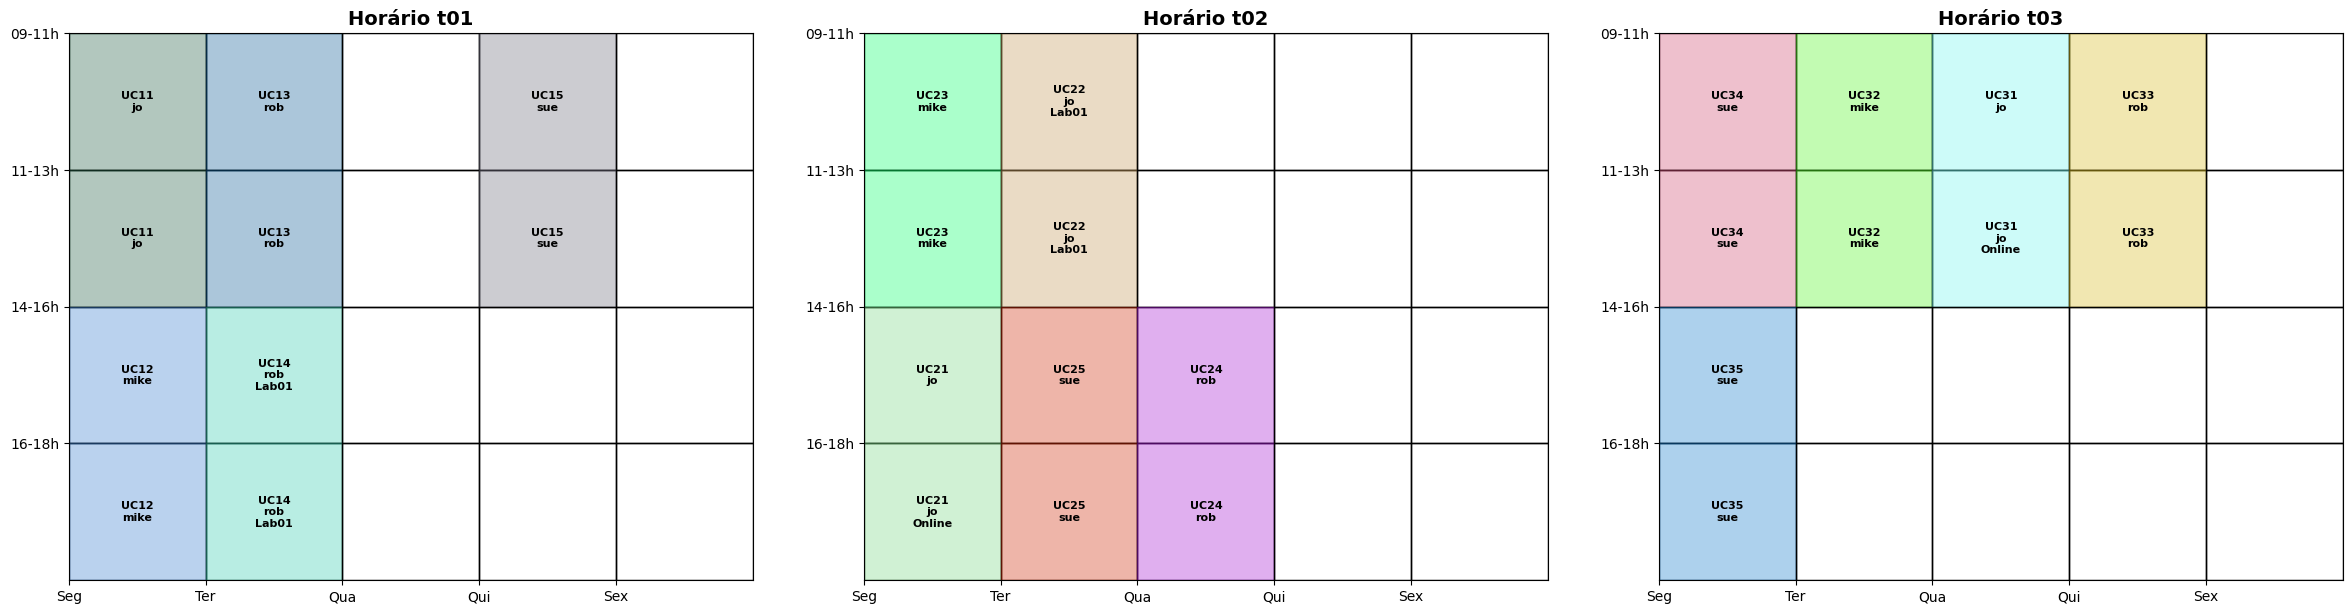

In [83]:
def dfs_recursive_stack(variables, constraints, stack, index):
    """
    variables: dicionário {var_name: dominio}
    constraints: lista de constraints
    stack: dicionário {UC: bloco} representando o caminho atual
    index: índice da próxima variável a explorar
    """
    # se todas as variáveis estão atribuídas, retornamos a solução
    if checkSolution(variables, stack):
        return stack

    uc = list(variables.keys())[index]

    # pegar a próxima variável que ainda não está no stack
    blocos = variables[uc]
    for bloco in blocos:
        stack[uc] = bloco  # atribuir valor à variável
        if constraintCheck(stack, constraints): #true continua, false backtrack
            solution = dfs_recursive_stack(variables, constraints, stack, index+1)
            if solution is not None:
                return solution # encontrou solução, desfaz a recursão
        stack.pop(uc)  # backtrack caso falha a constraintCheck ou não encontrou solução adiante
            
    return None  # nenhum valor válido


solution = dfs_recursive_stack(variables, constraints, {}, 0)

if solution:
    plot_schedule_by_class(solution, dados)
else:
    print("Nenhuma solução encontrada")

### BFS

Explora todos os nós no mesmo nível, encontra sempre a primeira solução, mas para problemas com muitas combinações é ineficiente.

Para este problema temos que uma UC pode estar em qualquer um dos 20 blocos, só depois é que verificamos se é válido esse bloco e com este dataset temos 15 UCs, 30 aulas semanais, o que vai levar a 30 niveis de profundidade de pesquisa e 20 combinações diferentes para cada UC e bloco.

Enquanto que ramos já considerados inválidos, são removidos da lista de stacks para continuar a serem explorados, queue, a complexidade deste dataset exige imensa memória.

Exemplo: chegar ao nível 6, 6 aulas de 30, ou 3 UCs de 15, ocupa entre 8 a 9 Gb de memória RAM para ~30 000 000 de stacks válidas por explorar

In [ ]:
from collections import deque

def bfs_level_by_level(variables, constraints):
    queue = deque()
    queue.append({})  # stack inicial (vazia)

    variable_keys = list(variables.keys())

    while queue:
        stack = queue.popleft()   # tira 1 caminho parcial

        # Se a stack já é uma solução completa
        if checkSolution(variables, stack):
            return stack  

        # Determinar qual UC atribuir a seguir
        next_var_index = len(stack)
        uc = variable_keys[next_var_index]

        # Expandir este ramo com todos os blocos possíveis
        for bloco in variables[uc]:
            new_stack = stack.copy()
            new_stack[uc] = bloco

            # Só colocamos na fila se respeita as restrições
            if constraintCheck(new_stack, constraints):
                queue.append(new_stack)

    return None  # sem solução

solution_bfs = bfs_level_by_level(variables, constraints)
if solution_bfs:
    plot_schedule_by_class(solution_bfs, dados)
else:
    print("Nenhuma solução encontrada")
